Classificação = Previsão de Classes, um tipo de Aprendizado Supervisionado

### MNIST - 70 mil pequenas imagens de dígitos escritos a mão por estudantes do ensino médio e funcionários do US Census Bureau.

In [45]:
# Carregando dataset mnist
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [46]:
y.shape

(70000,)

In [47]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=int8)

Temos 70 mil imagens de 28 x 28 pixels e cada imagem possui 784 características. Cada característica representa a intensidade de um pixel, de 0 (branco) a 255 (preto). 
Podemos pegar um vetor de característica de uma instância e remodelas para um array de 28 x 28 e exibir como imagem.

In [48]:
28*28

784

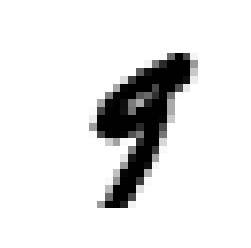

In [49]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

algum_digito = X[36000]
algum_digito_imagem = algum_digito.reshape(28,28)

plt.imshow(algum_digito_imagem, cmap= matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [50]:
# conferindo se o array de labels representa o que veio na imagem mesmo
y[36000]

9

In [66]:
y[2000]

5

In [51]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

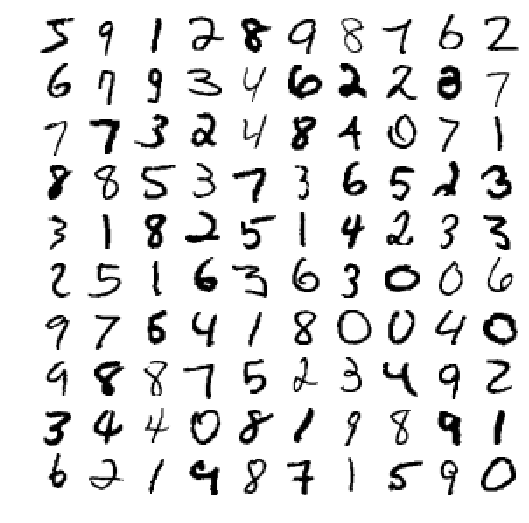

In [52]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
# save_fig("more_digits_plot")
plt.show()

O conjunto de dados MNIST já vem dividido em conjutno de treino e teste. Sendo os 60 mil primeiros o conjunto de teste e os 10 mil seguintes para teste.

In [53]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

É indicado embaralhar os registros de treinamento para garantir que todos os subconjuntos da validação cruzada sejam semelhantes. Pois sabemos que existem algoritmos de aprendizado que são sensíveis à ordem das instâncias de treinamento, e, se obtiverem muitas instâncias similares, funcionarão mal.

Válido observar que se estivermos trabalhando com séries temporais, por exemplo, não é indicado embaralhar os dados. Devemos sempre observar o contexto.

In [54]:
import numpy as np

embaralha_indice = np.random.permutation(60000)
X_train, y_train = X_train[embaralha_indice], y_train[embaralha_indice]

### Treinando um Classificador Binário

Vamos simplificar e fazer um treino para identificar inicialmente se um dígito é um número 5 ou não.

In [77]:
y_train.shape

(60000,)

In [79]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

y_train_9

array([False, False, False, ..., False, False, False])

Um exemplo de classificador binário é o *Gradiente Descendente Estocástico (SGD, do inglês)*. 
Este classificador tem a vantagem de conseguir lidar muito bem com grandes conjuntos de dados.

In [80]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [81]:
sgd_clf.predict([algum_digito])

array([False])

In [82]:
digito_5 = X[2000]
sgd_clf.predict([digito_5])

array([False])

### Medição de Desempenho

#### Medindo acurácia com validação cruzada

In [85]:
# fazendo a validação cruzada "manualmente"

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_9[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_9[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8914
0.9471
0.9405


A classe StratifiedKFold executa a amostragem estratificada para produzir subconjuntos que contêm uma proporção representativa de cada classe. Em cada interação, o código cria um clone do classificador, treina esse clone nas partes de treinamento e faz previsões na parte do teste. Então, conta o número de previsões corretas e entrega a proporção das previsões corretas.

In [87]:
# Avaliando o modelo SGDClassifier com cross_val_score()
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.8914, 0.9471, 0.9405])

Conhecendo um classificador frando para ver a diferença.

In [90]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [91]:
never_9_clf  = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9014 , 0.90085, 0.9003 ])

Não se iluda com a acurácia de 90%! Isso se dá simplesmente porque apenas cerca de 10% das imagens são "9", então, se sempre adivinharmos que uma imagem não é um 9, já acertaremos 90% das vezes.  
ATENÇÃO!

### Matriz de Confusão
Idela para contar o número de vezes que as instâncias da classe A são classificadas como classe B.

In [92]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

Assim como cross_val_score(), cross_val_predict() desempenha a validação cruzada K-fold, mas, em vez de retornar as pontuações da avaliação, ela retorna as previsões feitas em cada parte do teste.

In [93]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[50962,  3089],
       [ 1331,  4618]], dtype=int64)

Cada linha representa uma classe real, enquanto cada coluna representa uma classe prevista.

In [94]:
# simulando um classificador perfeito
y_train_perfect_predictions = y_train_9

confusion_matrix(y_train_9, y_train_perfect_predictions)

array([[54051,     0],
       [    0,  5949]], dtype=int64)

### Precisão e Revocação

In [95]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9, y_train_pred)

0.5991955365252368

In [98]:
4618 / (4618 + 3089)

0.5991955365252368

In [96]:
recall_score(y_train_9, y_train_pred)

0.776264918473693

In [99]:
4618 / (4618 + 1331)

0.776264918473693

In [100]:
#f1 score é a média harmônica da precisão e revocação
4618 / (4618 + (3089+1331)/2)

0.6763327475102519

In [101]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred)

0.6763327475102519

Aumentar a precisão reduz a revocação, e vice-versa. Isso é chamado de compensação da precisão/revocação.

### Compensação da Precisão/Revocação

In [103]:
# Usando a função decision_function temos o valor da pontuação de cada instância
y_scores = sgd_clf.decision_function([algum_digito])
y_scores

array([-70882.7302339])

In [105]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [106]:
threshold = -70900
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Decidimos qual limiar usar, utilizando a função cross_val_predict()

In [108]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")
y_scores

array([ -803958.5047564 ,   -20682.51830872, -1124722.68766276, ...,
        -155996.3590629 ,  -683300.52475525,  -326516.56065593])

In [109]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

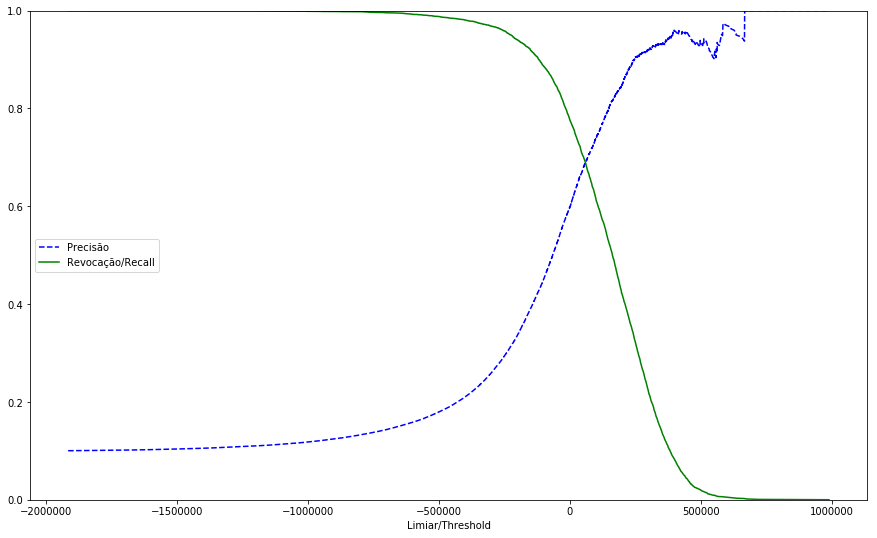

In [113]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "g-", label="Revocação/Recall")
    plt.xlabel("Limiar/Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plt.figure(figsize=(15,9))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [114]:
(y_train_pred == (y_scores > 0)).all()

True

In [115]:
y_train_pred_90 = (y_scores > 70000)

In [116]:
precision_score(y_train_9, y_train_pred_90)

0.7024734982332156

In [117]:
recall_score(y_train_9, y_train_pred_90)

0.6683476214489831

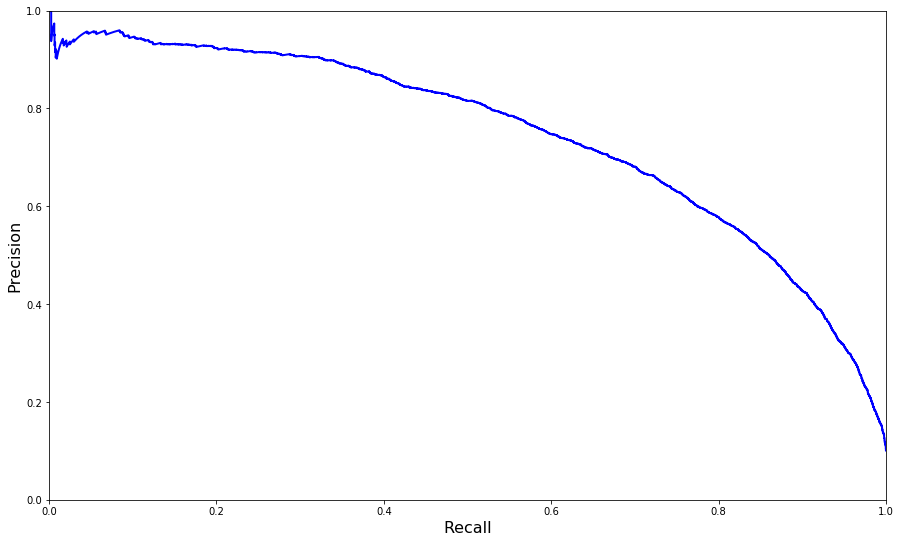

In [119]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(15,9))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

### Curva ROC

- Comumente utilizada com classificadores binários
- Taxa de Verdadeiros Positivos -TPR x Taxa de Falsos Positivos - FPR
- TNR = Taxa de Verdadeiros Negativos = Especificidade
- Curva ROC = sensibilidade (revocação) x TNR = Especificidade

In [120]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

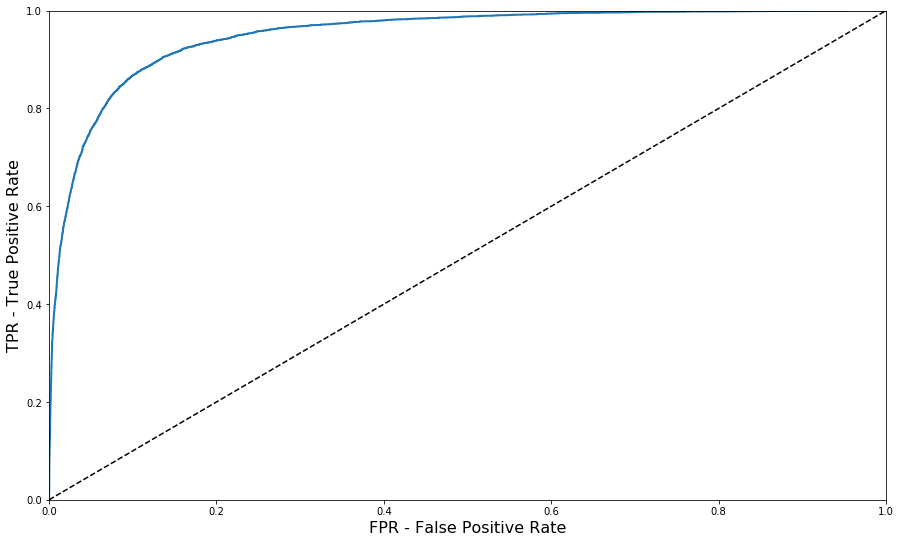

In [123]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR - False Positive Rate', fontsize=16)
    plt.ylabel('TPR - True Positive Rate', fontsize=16)
    
plt.figure(figsize=(15,9))
plot_roc_curve(fpr, tpr)
plt.show()

- Existe uma compensação: quanto maior a revocação (TPR), mais falsos positivos (FPR) o classificador produz.
- A linha pontilhada representa a curva ROC de um classificador puramente aleatório
- Um bom classificador fica o mais distante dessa linha possível (em direção ao canto superior esquerdo)
- Comparamos classificadores medindo a área abaixo da curva (AUC)
- Um classificador perfeito terá o ROC AUC = 1
- Um classificador puramente aleatório terá um ROC AUC = 0,5

In [124]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_9, y_scores)

0.9507156939204853

- Devemos preferir a curva PR sempre que a classe positiva for rara ou quanto se preocupar mais com os falsos positivos do que com os falsos negativos
- Devemos usar a curva ROC em caso contrário :)

#### Treinar RandomForestClassifier e comparar a curva ROC e a pontuação ROC AUC

In [125]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [126]:
# neste caso temos como retorno as probabilidades e não as pontuções, mas podemos utiilizar a probabilidade da classe positiva como a pontuação
y_scores_forest = y_probas_forest[:, 1] # pontuação = probabilidade da classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

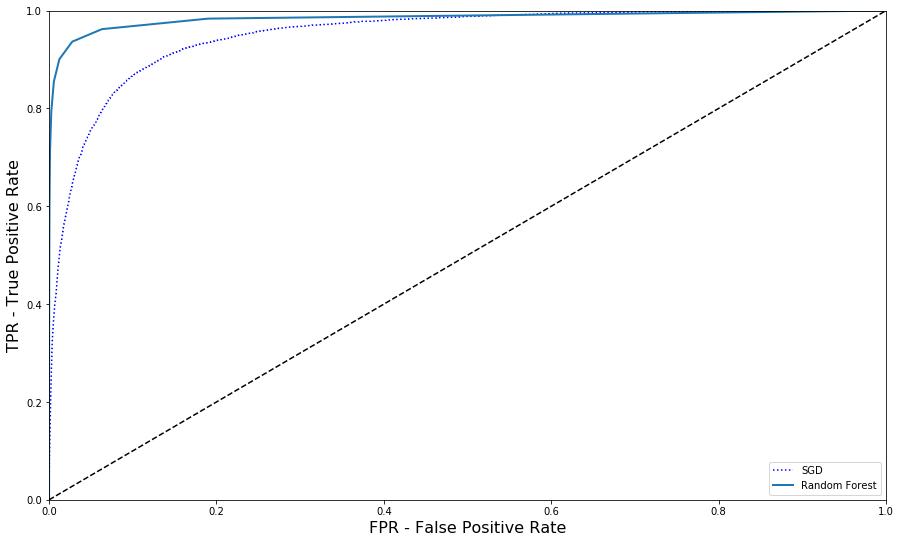

In [127]:
plt.figure(figsize=(15,9))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [128]:
roc_auc_score(y_train_9, y_scores_forest)

0.984609440989812

In [131]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)
precision_score(y_train_9, y_train_pred_forest)

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9705942833641785

In [130]:
recall_score(y_train_9, y_train_pred_forest)

0.7934106572533199

- Dá para ver que a curva ROC do RandomForestClassifier parece bem melhor que a do SGDClassifier
- E a pontuação ROC AUC também é significativametne melhor

### Classificação Multiclasse

- Floresta Aleatória (multiclasse)
- Naive-Bayes (multiclasse)
- Máquinas de Vetores de Suporte (estritamente binário) e não lidam bem com conjuntos grandes de dados
- Classificadores lineares (estritamente binário)

**No entanto, existe estratégias para realizar a classificação multiclasse com classificadores binários múltiplos**
- Por exemplo: treinar 10 classificadores binários, um para cada dígito (estratégia um contra todos - OvA)
- Ou treinar um classificador binário para cada par de dígitos: 0x1, 0v2, 1v2, etc. OvO - one-versus-one.

In [133]:
# o scikit-learn detecta quando tentamos usar um classificador binário para tarefa de multiclasse e automaticamente
# realiza o OvA. Exceto os classificadores SVM que realizam OvO.

# tentando com o SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([algum_digito])

array([9], dtype=int8)

In [134]:
sgd_clf.predict([digito_5])

array([8], dtype=int8)

In [135]:
# a função decision_function mostra a pontuação de cada instância do OvA
some_digit_scores = sgd_clf.decision_function([algum_digito])
some_digit_scores

array([[-900772.8534414 , -407225.47810564, -870116.33583314,
         -86883.51868218, -208431.17257012, -195199.50111705,
        -813285.33021418, -244866.3639191 , -364464.45109793,
         -70882.7302339 ]])

In [136]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [138]:
np.argmax(some_digit_scores)

9

Podemos escolher se queremos usar um contra um ou um contra todos através das classes *OneVsOneClassifier* e *OneVsRestClassifier*.

In [139]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([algum_digito])

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([9], dtype=int8)

In [140]:
ovo_clf.predict([digito_5])

array([5], dtype=int8)

In [141]:
len(ovo_clf.estimators_)

45

In [142]:
# Treinando RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([algum_digito])

D:\Users\elain\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([9], dtype=int8)

In [143]:
forest_clf.predict([digito_5])

array([5], dtype=int8)

In [144]:
forest_clf.predict_proba([algum_digito])

array([[0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0.9]])

In [145]:
forest_clf.predict_proba([digito_5])

array([[0. , 0. , 0. , 0. , 0.1, 0.8, 0.1, 0. , 0. , 0. ]])

In [146]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86287742, 0.86989349, 0.85177777])

In [147]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.93996201, 0.93709685, 0.94024104])

In [148]:
# Experimentando dimensionar as entradas do classificador para melhorar a precisão
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91171766, 0.90969548, 0.90973646])

In [149]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94006199, 0.93724686, 0.939991  ])

### Análise de Erro

Em um projeto real deveríamos seguir os passos corretos:
- explorar opções de preparação de dados
- testar vários modelos
- selecionar os melhores
- ajustar seus hiperparâmetros usando GridSearchCV
- automatizar o máximo possível

Vamos supor que encontramos um modelo promissor e queremos encontrar maneiras de melhorá-lo. Uma maneira de fazer isso é analisar os tipos de erros que ele comete.
- Primeiro olhe para a matriz de confusão

In [151]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[5738,    2,   21,    8,   11,   43,   47,    8,   41,    4],
       [   1, 6489,   46,   26,    5,   41,    7,    9,  106,   12],
       [  58,   36, 5341,   92,   81,   27,   91,   58,  159,   15],
       [  48,   44,  139, 5362,    3,  221,   33,   54,  131,   96],
       [  20,   28,   36,    9, 5388,    8,   49,   25,   76,  203],
       [  73,   48,   35,  176,   69, 4599,  104,   27,  198,   92],
       [  33,   24,   47,    2,   46,   92, 5627,    5,   41,    1],
       [  24,   18,   72,   28,   47,    9,    6, 5820,   15,  226],
       [  59,  154,   70,  167,   14,  144,   55,   23, 5036,  129],
       [  49,   35,   23,   91,  169,   34,    3,  241,   81, 5223]],
      dtype=int64)

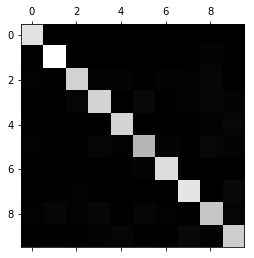

In [152]:
# plotando é mais fácil de entender
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

In [153]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

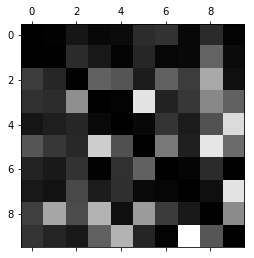

In [154]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

Lembrete:
- linhas representam classes reais
- colunas representam as classes previstas
- colunas muito brilhantes nesse plot indicam que muitas imagens foram classificadas erroneamente

Vendo essa matriz de confusão conseguimos perceber que:
- a classificação dos dígitos 8 e 9 devem ser melhorados
- existe uma confusão grande entre 3 e 5

Alternativas:
- podemos tentar melhorar o classificador com algum algortimo para contar o número de curvas fechadas( o 8 tem dois e o 6 tem um, enquanto o 5 tem nenhum)
- podemos pré-processar as imagens usando por exemplo: Scikit-Image, Pillow ou OpenCV

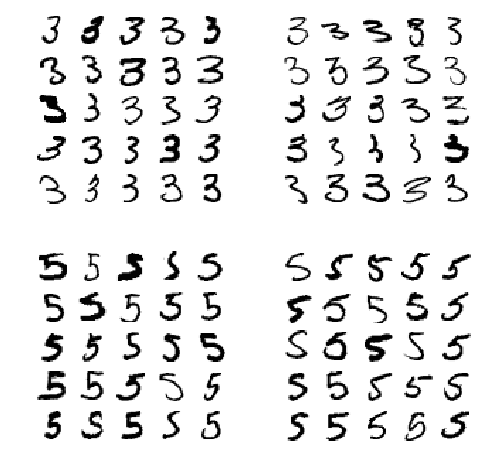

In [156]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- Os dois blocos 5x5 à esquerda mostram dígitos classificados como 3
- Os dois blocos 5x5 à direita mostram dígitos classificados como 5
- Alguns estão tão mal escritos que mesmo um ser humano teria problemas para classificar.

Porém vale lembrar que usamos o SGDClassifier simples, que é um modelo linear. Tdo o que ele faz é atribuir um peso por classe a cada pixel, e, quando ele vê uma nova imagem, apenas resume as intensidades dos pixels analisados para obter uma pontuação para cada classe. Como os 3 e 5 diferem apenas por alguns pixels, esse modelo facilmente os confundirá.

### Classificação Multilabel

In [158]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

O código cria um array y_multilabel contendo dois rótulos-alvo para cada imagem numérica:
- o primeiro indica se o dígito é ou não é grande (7,8,9)
- o segundo indica se é ou não é ímpar.

In [159]:
# realizando previsão
knn_clf.predict([algum_digito])

array([[ True,  True]])

In [160]:
knn_clf.predict([digito_5])

array([[False,  True]])

In [161]:
# calculando a pontuação média F1
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9774747128458857

In [162]:
# dando o mesmo peso a cada rótulo
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9788420151666704

### Classificação Multioutput
É uma generalizaçÃo da classificaçÃo multilabel em que cada rótulo pode ser multiclasse (ou seja, pode ter masi de dois valores possíveis)

Para ilustrar vamos construir um sistema que remova ruído das imagens. Entramos com uma imagem numérica ruidosa e mostrará uma imagem numérica limpa.

In [163]:
# adicionando ruído às imagens 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [170]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

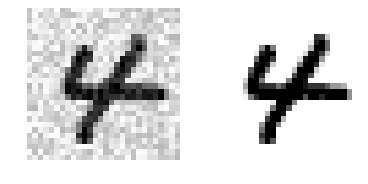

In [171]:
# a esquerda temos a imagem confusa de entrada e a direita a imagem-alvo limpa
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

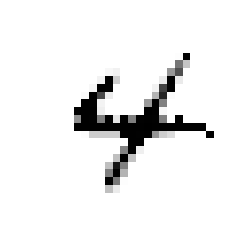

In [172]:
# treinando o classificador para fazer com que ele limpe a imagem
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)